In [2]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 

In [3]:
#User enters data here

file = 'C14.xlsx' #file name
samples = ['WT','KCM272','T137A'] #name of samples
### ^^Do these have to be in order? 
### ^^Yes, they have to be in order of appearance. I'm trying to see if I can get that fixed
numVials = [3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 
chains = ['C8','C10','C12_1,','C12','C14_1','C14','C16_1','C16','C18_1','C18'] #chain lengths

#Graph options
title = 'BTE Mutants' #graph title
ylabel = 'mg/L FAME' #y axis label
graphWidth = 9 #Default 6.0
graphHeight = 4 #Default 4.0
barWidth = 0.8 #Default 0.8
legendLocation = 'upper left' #Default 'best' or Choose: 'upper right/center/left', 'lower right/center/left'
#plt.rcParams["font.family"] = "Times New Roman"
### Python Default
plt.rcParams["font.family"] = 'DejaVu Sans'

#Should be the same from batch to batch
sheet = 'Corrected Concentration' #sheet with corrected concentration data

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!') #love it
    
#avgMat = 0

In [4]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    print(numTotSamples)
    print(numChains)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

In [5]:
#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

In [6]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+2]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = np.std(rearranged[0][r][c*3:(c*3)+2])
        
    return avgMat,stdevMat

In [7]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, title, ylabel):
    global avgMat
    
    csfont = {'fontname':'Times New Roman'}
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)

    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    plt.figure(figsize=(graphWidth,graphHeight))
    fistplot = plt.bar(ind, firstMean, width=.1, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width=.1, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,samples)
    plt.legend(bbox_to_anchor = [1,.5], loc='center left')
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show

In [8]:
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheet_name=sheet)
    correctedConc = []
    title = df[0][0].split('-')[0]
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        sample = df[0][i] if isinstance(df[0][i], float) or isinstance(df[0][i], int) else df[0][i].split('-')[0]
        if isinstance(sample, str) and not sample == 'Peak#':
            title = sample
        if title in samples and isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
    print(len(correctedConc))
    return correctedConc

90
9
10


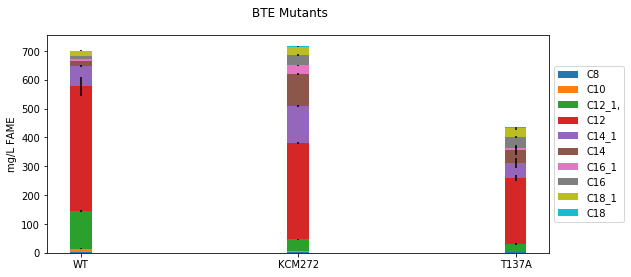

In [9]:
createBarChart(file, sheet, samples, numVials, chains, title, ylabel)

In [10]:
avgMat

array([[   3.42115603,    2.83267068,    1.69111202],
       [  10.97901984,    1.88248451,    1.71871597],
       [ 131.68082551,   41.83973555,   27.34019402],
       [ 430.90120675,  334.06074573,  230.05054447],
       [  69.00955358,  127.70312346,   50.2921867 ],
       [  18.34114655,  110.12768747,   44.79235027],
       [   8.01902561,   30.99210124,    9.15676691],
       [  10.57721261,   35.75074594,   36.76780004],
       [  17.36489279,   30.0087222 ,   30.1736679 ],
       [   0.84982142,    1.90434167,    2.93580922]])

In [11]:
num_Exp = len(samples)
library_summary = np.zeros((num_Exp,2)) 
print(library_summary)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [12]:
# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    titer = 0
    for analyte in avgMat:
        titer = titer + analyte[sample]
        
    library_summary[sample, 1] = titer
    

# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    C14_titer = 0
    C12_titer = 0
    titer = 0
    counter = 1
    for analyte in avgMat[2:6]: #looking at C12 and C14 fractions only
        if counter < 3:
            C12_titer = C12_titer + analyte[sample]
        
        elif counter >= 3:
            C14_titer = C14_titer + analyte[sample]
            
        counter = counter+1
    
    ratio = C12_titer/C14_titer
    library_summary[sample, 0] = ratio

In [13]:
a = np.round(library_summary,2)

In [14]:
np.trunc(a*10**1)/(10**1)

array([[   6.4,  701.1],
       [   1.5,  717.1],
       [   2.7,  434.9]])

In [15]:
WT_slice = avgMat[:,0]
WT_sum = np.sum(WT_slice)

KCM272_slice = avgMat[:,1]
KCM272_sum = np.sum(KCM272_slice)
T137A_slice = avgMat[:,2]
T137A_sum = np.sum(T137A_slice)

In [16]:
WT_dist = []
for i in WT_slice:
    fraction = i/WT_sum
    WT_dist.append(fraction)


KCM272_dist = []
for i in KCM272_slice:
    fraction = i/KCM272_sum
    KCM272_dist.append(fraction)
    
T137A_dist = []
for i in T137A_slice:
    fraction = i/T137A_sum
    T137A_dist.append(fraction)
    

In [17]:
count = 0

C12_1 = []
C12 = []
C14_1 = []
C14 = []
C16_1 = []
C16 = []
C18 = []
C18_1 = []
for x, y, z in zip(WT_dist, KCM272_dist, T137A_dist):
    if count == 2:
        C12_1.append(x)
        C12_1.append(y)
        C12_1.append(z)
    elif count == 3:
        C12.append(x)
        C12.append(y)
        C12.append(z)
    elif count == 4:
        C14_1.append(x)
        C14_1.append(y)
        C14_1.append(z)
    elif count == 5:
        C14.append(x)
        C14.append(y)
        C14.append(z)
    elif count == 6:
        C16_1.append(x)
        C16_1.append(y)
        C16_1.append(z)
    elif count == 7:
        C16.append(x)
        C16.append(y)
        C16.append(z)
    elif count == 8:
        C18_1.append(x)
        C18_1.append(y)
        C18_1.append(z)
    elif count == 9:
        C18.append(x)
        C18.append(y)
        C18.append(z)
    
    count = count + 1

In [18]:
C12

[0.61456889363977729, 0.4658480644946732, 0.52895014115762862]

In [19]:
C12_1

[0.18780856953065239, 0.058345555627997404, 0.062862704875961753]

In [20]:
C18_1

[0.024766519062245966, 0.04184719495947118, 0.069377648865328739]

In [21]:
T137A_dist

[0.0038883365668561133,
 0.0039518057192873511,
 0.062862704875961753,
 0.52895014115762862,
 0.1156357152428286,
 0.102990062689392,
 0.021053952131148586,
 0.084539391396596747,
 0.069377648865328739,
 0.0067502413549714634]

In [23]:
WT_dist

[0.0048793924100603795,
 0.015658726339826675,
 0.18780856953065239,
 0.61456889363977729,
 0.098424242792116132,
 0.026158892037864492,
 0.01143706171567359,
 0.015085652468402027,
 0.024766519062245966,
 0.0012120500033810915]

In [24]:
chains = ['C8','C10','C12_1,','C12','C14_1','C14','C16_1','C16','C18_1','C18']

In [25]:
import pickle

In [26]:
pickle.dump([T137A_dist,WT_dist,chains], open('T137A_distribution.p', 'wb'))